## Stress Testing and Scenario Analysis

In the baseline configuration, the Lombard loan appears conservatively structured, with no margin call events observed under normal market conditions.  
Stress testing is therefore required to understand how much buffer the structure actually has when markets move into adverse territory.

Rather than attempting to forecast future price dynamics, the analysis focuses on deterministic stress scenarios applied on top of the historical price path. This allows me to isolate pure market stress effects while avoiding additional modelling assumptions that could obscure the interpretation of results.

The stress scenarios are designed to answer a practical risk management question:

*How would the loan-to-value ratio evolve if markets experienced a sudden and severe deterioration, and would margin call or liquidation thresholds be breached?*

The stress framework builds directly on the baseline model developed in the previous notebooks. Loan amount, collateral composition and haircut assumptions are kept unchanged. Only asset prices are shocked, ensuring that the observed effects are entirely driven by market movements rather than by structural changes to the loan.

This approach mirrors how stress testing is commonly used in collateralised lending: not as a forecasting tool, but as a complementary risk lens to assess tail risk and extreme yet plausible scenarios.


## Assumptions for Scenario & Shock Analysis

Deterministic shocks are applied on top of the historical price path within a defined one-year stress window.  
This approach preserves the underlying market dynamics observed in the data, while imposing an additional layer of severe but plausible stress.

By doing so, the analysis avoids rewriting history and instead simulates how the Lombard structure would have behaved if markets had experienced a materially worse deterioration during specific stress periods.

The objective is to test whether margin call or liquidation thresholds would be breached under tail-risk conditions, given the existing collateral composition, haircuts and loan structure.


In [ ]:
import pandas as pd
import numpy as np

Final_matrix = pd.read_excel(r"Final_matrix.xlsx", index_col='Date')
LTV_Haircuts_matrix = pd.read_excel(r"LTV_Haircuts_matrix.xlsx", index_col='Date')

In [2]:
LTV_Haircuts_matrix

,Equity_MV,Bond_MV,Cash_MV,Equity_Eligible_Value,Bond_Eligible_Value,Cash_Eligible_Value,Tot_Eligible,LTV_daily,% LTV_daily,Margin_FLAG,Liquidation_FLAG
Date,,,,,,,,,,,
2020-01-02,500021.76,399998.49,50000,350015.232,339998.7165,47500,737513,0.637277,64,No risks,No risks
2020-01-03,499567.36,400769.20,50000,349697.152,340653.8200,47500,737850,0.636986,64,No risks,No risks
2020-01-06,498476.80,400769.20,50000,348933.760,340653.8200,47500,737087,0.637645,64,No risks,No risks
2020-01-07,502475.52,400769.20,50000,351732.864,340653.8200,47500,739886,0.635233,64,No risks,No risks
2020-01-08,504656.64,399998.49,50000,353259.648,339998.7165,47500,740758,0.634485,63,No risks,No risks
...,...,...,...,...,...,...,...,...,...,...,...
2026-01-05,1016583.68,379960.03,50000,711608.576,322966.0255,47500,1082074,0.434351,43,No risks,No risks
2026-01-06,1019128.32,379189.32,50000,713389.824,322310.9220,47500,1083200,0.433900,43,No risks,No risks
2026-01-07,1024035.84,380730.74,50000,716825.088,323621.1290,47500,1087946,0.432007,43,No risks,No risks


### Scenario 1 — Equity Crash (COVID core window)

This scenario focuses on the most acute phase of the COVID market sell-off.  
An additional equity price shock of **-15%** is applied on top of the observed historical prices during the two-month window from **2020-03-01 to 2020-04-30**.

The objective is to assess whether a deeper equity drawdown during the peak of market stress would have been sufficient to trigger margin call events, given the existing collateral structure and haircuts.

### Scenario 2 — Credit Stress

This scenario represents a prolonged credit deterioration environment, inspired by the tightening financial conditions observed in 2022.

An additional equity shock of **-10%** and a bond price shock of **-15%** are applied over a one-year window from **2022-01-01 to 2022-12-31**.

The scenario is designed to test the resilience of the Lombard structure under sustained pressure on both risk assets and fixed income, rather than a short-lived market crash.

### Scenario 3 — Severe Combined Tail (Liquidation Test)

This scenario represents a severe combined tail event and is explicitly designed as a liquidation stress test.

A simultaneous equity shock of **-40%** and bond price shock of **-20%** are applied over a one-year window from **2020-03-01 to 2021-02-28**, covering an extended period of extreme market dislocation.

The purpose of this scenario is to evaluate whether liquidation thresholds would be breached under extreme but still plausible market conditions, and to assess the effectiveness of collateral diversification and haircuts in protecting the lender.




In [3]:
initial_loan = 470000
margin_call = 0.75
liquidation_call = 0.90
h_equity = 0.30
h_bond= 0.15

#scenario 1
shock_equity_1 = 1 - 0.15
shoch_bond_1 =  1
#scenario 2
shock_equity_2 = 1 -0.10
shoch_bond_2 =  1 - 0.15
#scenario 3
shock_equity_3 = 1 - 0.40
shoch_bond_3 =  1 - 0.20

def calculatio_scenario_and_margin(df, shock_equity = 1, shock_bond = 1):
    
    # Equity
    df['Equity_MV'] = df['Equity_MV'] * (shock_equity)
    df ['Equity_Eligible_Value'] = df['Equity_MV'] * (1-h_equity)

    # Bond
    df['Bond_MV'] = df['Bond_MV'] * (shock_bond)
    df ['Bond_Eligible_Value'] = df['Bond_MV'] * (1-h_bond)

    df['Tot_Eligible'] = df['Equity_Eligible_Value'] + df['Bond_Eligible_Value'] + df['Cash_Eligible_Value']
    df['LTV_daily'] = initial_loan / df['Tot_Eligible']
    df['% LTV_daily'] = round(((initial_loan / df['Tot_Eligible']) * 100))

    # condition Margin/Liquidation Call
    margin_condition = df['LTV_daily']>= margin_call
    liquidation_condition = df['LTV_daily']>= liquidation_call

    df['Margin_FLAG'] = np.where(margin_condition, "Margin CALL", "No risks")
    df['Liquidation_FLAG'] = np.where(liquidation_condition, "Liquidation CALL", "No risks")

    df = df.set_index('Date')

    return df


def scenarios (df, scenario_1 = False, scenario_2 = False, scenario_3 = False):
    df = df.copy()
    df = df.reset_index()

    if scenario_1 == True: # Equity crash
        
        start_date = '2020-03-01'
        end_date = '2020-04-30'
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

        df = calculatio_scenario_and_margin(df, shock_equity = shock_equity_1, shock_bond = shoch_bond_1)

        return df
    
    if scenario_2 == True: # Credit Stress 

        start_date = '2022-01-01'  
        end_date = '2022-12-31'
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

        df = calculatio_scenario_and_margin(df, shock_equity = shock_equity_2, shock_bond = shoch_bond_2)

        return df

    if scenario_3 == True: # worst case scenario

        start_date = '2020-03-01'  
        end_date = '2021-02-28'
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

        df = calculatio_scenario_and_margin(df, shock_equity = shock_equity_3, shock_bond = shoch_bond_3)

        return df

Equity_crash_scenario = scenarios(df = LTV_Haircuts_matrix, scenario_1=True)
Credit_stress_scenario = scenarios(LTV_Haircuts_matrix, scenario_2=True)
worst_case_scenario = scenarios(LTV_Haircuts_matrix, scenario_3=True)


In [4]:
Equity_crash_scenario.head(10)

,Equity_MV,Bond_MV,Cash_MV,Equity_Eligible_Value,Bond_Eligible_Value,Cash_Eligible_Value,Tot_Eligible,LTV_daily,% LTV_daily,Margin_FLAG,Liquidation_FLAG
Date,,,,,,,,,,,
2020-03-02,397672.704,410017.72,50000,278370.8928,348515.0620,47500,674385.9548,0.696930,70.0,No risks,No risks
2020-03-03,399758.400,410788.43,50000,279830.8800,349170.1655,47500,676501.0455,0.694751,69.0,No risks,No risks
2020-03-04,404393.280,411559.14,50000,283075.2960,349825.2690,47500,680400.5650,0.690770,69.0,No risks,No risks
2020-03-05,404702.272,411559.14,50000,283291.5904,349825.2690,47500,680616.8594,0.690550,69.0,No risks,No risks
2020-03-06,383072.832,413871.27,50000,268150.9824,351790.5795,47500,667441.5619,0.704181,70.0,No risks,No risks
2020-03-09,359898.432,414641.98,50000,251928.9024,352445.6830,47500,651874.5854,0.720998,72.0,No risks,No risks
2020-03-10,359898.432,411559.14,50000,251928.9024,349825.2690,47500,649254.1714,0.723908,72.0,No risks,No risks
2020-03-11,362447.616,410788.43,50000,253713.3312,349170.1655,47500,650383.4967,0.722651,72.0,No risks,No risks
2020-03-12,333093.376,404622.75,50000,233165.3632,343929.3375,47500,624594.7007,0.752488,75.0,Margin CALL,No risks


In [5]:
worst_case_scenario

,Equity_MV,Bond_MV,Cash_MV,Equity_Eligible_Value,Bond_Eligible_Value,Cash_Eligible_Value,Tot_Eligible,LTV_daily,% LTV_daily,Margin_FLAG,Liquidation_FLAG
Date,,,,,,,,,,,
2020-03-02,280710.144,328014.176,50000,196497.1008,278812.0496,47500,522809.1504,0.898990,90.0,Margin CALL,No risks
2020-03-03,282182.400,328630.744,50000,197527.6800,279336.1324,47500,524363.8124,0.896324,90.0,Margin CALL,No risks
2020-03-04,285454.080,329247.312,50000,199817.8560,279860.2152,47500,527178.0712,0.891539,89.0,Margin CALL,No risks
2020-03-05,285672.192,329247.312,50000,199970.5344,279860.2152,47500,527330.7496,0.891281,89.0,Margin CALL,No risks
2020-03-06,270404.352,331097.016,50000,189283.0464,281432.4636,47500,518215.5100,0.906959,91.0,Margin CALL,Liquidation CALL
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,331257.600,325547.904,50000,231880.3200,276715.7184,47500,556096.0384,0.845178,85.0,Margin CALL,No risks
2021-02-23,328258.560,325547.904,50000,229780.9920,276715.7184,47500,553996.7104,0.848380,85.0,Margin CALL,No risks
2021-02-24,332893.440,324931.336,50000,233025.4080,276191.6356,47500,556717.0436,0.844235,84.0,Margin CALL,No risks


### Early-Warning Signals & Margin Remediation (Top-Up)

The baseline model identifies margin call and liquidation breaches using fixed LTV thresholds.  
In practice, risk monitoring also relies on early-warning indicators (how close the structure is to a threshold, how fast risk is building up, and whether breaches persist).

In this section I add three simple but realistic monitoring signals, and quantify the collateral top-up required to restore the structure to a safer LTV level when margin calls occur.


In [22]:
import pandas as pd
import numpy as np

def enrich_risk_monitoring( df, *, loan_amount: float, margin_call: float = 0.75, liquidation_call: float = 0.90, amber_level: float = 0.70, target_ltv: float = 0.65,
                            roc_days: int = 5, roc_threshold: float = 0.03,   # +3pp in roc_days (e.g., 5 days)
                            streak_days: int = 3, eligible_col: str = "Tot_Eligible", ltv_col: str = "LTV_daily"):
    """
    Adds early-warning signals + top-up logic to a scenario dataframe.

    Required columns:
      - Tot_Eligible (or eligible_col)
      - LTV_daily (or ltv_col)
    Index:
      - Date (DatetimeIndex). If not, it will attempt to convert.

    Outputs (new columns):
      - dist_to_MC, dist_to_LIQ
      - warning_level (GREEN/AMBER/RED/BLACK)
      - ltv_change_{roc_days}d, roc_warning
      - mc_streak, streak_warning
      - TopUp_to_MC, TopUp_to_Target
    """
    out = df.copy()
    out.index = pd.to_datetime(out.index)
    out = out.sort_index()

    # --- Safety checks (simple + helpful errors) ---
    if eligible_col not in out.columns:
        raise ValueError(f"Missing column '{eligible_col}'. Available columns: {list(out.columns)}")
    if ltv_col not in out.columns:
        raise ValueError(f"Missing column '{ltv_col}'. Available columns: {list(out.columns)}")

    # --- A) Distance to thresholds (buffer) ---
    out["dist_to_MC"] = margin_call - out[ltv_col]
    out["dist_to_LIQ"] = liquidation_call - out[ltv_col]

    # --- B) Warning level (readable monitoring states) ---
    out["warning_level"] = "GREEN"
    out.loc[out[ltv_col] >= amber_level, "warning_level"] = "AMBER"
    out.loc[out[ltv_col] >= margin_call, "warning_level"] = "RED"
    out.loc[out[ltv_col] >= liquidation_call, "warning_level"] = "BLACK"

    # --- C) Speed warning (LTV jump) ---
    change_col = f"ltv_change_{roc_days}d"
    out[change_col] = out[ltv_col] - out[ltv_col].shift(roc_days)
    out["roc_warning"] = out[change_col] >= roc_threshold

    # --- D) Persistence warning (consecutive MC days) ---
    above_mc = out[ltv_col] >= margin_call
    out["mc_streak"] = above_mc.groupby((above_mc != above_mc.shift()).cumsum()).cumcount() + 1
    out.loc[~above_mc, "mc_streak"] = 0
    out["streak_warning"] = out["mc_streak"] >= streak_days

    # --- E) Top-Up logic (remediation) ---
    # Compliance: get back below MC
    eligible_required_mc = loan_amount / margin_call
    # Conservative: restore to target LTV (buffer)
    eligible_required_target = loan_amount / target_ltv

    out["TopUp_to_MC"] = np.maximum(0, eligible_required_mc - out[eligible_col])
    out["TopUp_to_Target"] = np.maximum(0, eligible_required_target - out[eligible_col])

    return out


### How the enrichment function is used

The function is applied to the baseline dataset and to each stress scenario.  
All scenarios share the same deal structure (loan amount, haircuts, thresholds), therefore the early-warning and top-up outputs are directly comparable across scenarios.


In [18]:
# ---- Your deal parameters (use your real values) ----
loan_amount = 470_000   # the loan used in your model
margin_call = 0.75
liquidation_call = 0.90

# Optional monitoring settings (feel free to keep defaults)
target_ltv = 0.65       # where you want to go back after a margin call
amber_level = 0.70      # early warning level
roc_days = 5
roc_threshold = 0.03    # +3 percentage points in 5 days
streak_days = 3         # persistent breach threshold

# ---- Apply to baseline + scenarios ----
baseline_enriched = enrich_risk_monitoring(
    LTV_Haircuts_matrix,
    loan_amount=loan_amount,
    margin_call=margin_call,
    liquidation_call=liquidation_call,
    amber_level=amber_level,
    target_ltv=target_ltv,
    roc_days=roc_days,
    roc_threshold=roc_threshold,
    streak_days=streak_days,
    eligible_col="Tot_Eligible",
    ltv_col="LTV_daily"
)

equity_enriched = enrich_risk_monitoring(
    Equity_crash_scenario,
    loan_amount=loan_amount,
    margin_call=margin_call,
    liquidation_call=liquidation_call,
    amber_level=amber_level,
    target_ltv=target_ltv,
    roc_days=roc_days,
    roc_threshold=roc_threshold,
    streak_days=streak_days
)

credit_enriched = enrich_risk_monitoring(
    Credit_stress_scenario,
    loan_amount=loan_amount,
    margin_call=margin_call,
    liquidation_call=liquidation_call,
    amber_level=amber_level,
    target_ltv=target_ltv,
    roc_days=roc_days,
    roc_threshold=roc_threshold,
    streak_days=streak_days
)

worst_enriched = enrich_risk_monitoring(
    worst_case_scenario,
    loan_amount=loan_amount,
    margin_call=margin_call,
    liquidation_call=liquidation_call,
    amber_level=amber_level,
    target_ltv=target_ltv,
    roc_days=roc_days,
    roc_threshold=roc_threshold,
    streak_days=streak_days
)


### Interpretation of the outputs

The distance-to-threshold metrics quantify the remaining buffer before margin call or liquidation events are triggered, providing a direct measure of available headroom. The warning level condenses the current risk state into a high-level monitoring signal, while the LTV rate of change highlights situations where risk is deteriorating rapidly, even if absolute LTV levels remain below critical thresholds.

The margin call streak metric differentiates isolated, short-lived breaches from sustained stress conditions, helping to identify structurally risky positions. Finally, the collateral top-up estimates translate risk signals into actionable terms, indicating the additional collateral required either to exit the margin-call zone or to restore a conservative target LTV buffer.


### Scenario Summary (with Early-Warning & Top-Up)

The table below summarises each stress scenario using a small set of metrics that are commonly monitored in collateralised lending.

In addition to maximum LTV and threshold breaches, the summary includes persistence (streak), speed (LTV jump), and the remediation amount required to restore the structure to safer levels.


In [19]:
def scenario_summary_v2(df, scenario_name, window_label, margin_call=0.75, liquidation_call=0.90):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    max_ltv = float(df["LTV_daily"].max())
    mc_days = int((df["LTV_daily"] >= margin_call).sum())
    liq_days = int((df["LTV_daily"] >= liquidation_call).sum())

    max_streak = int(df["mc_streak"].max()) if "mc_streak" in df.columns else 0
    worst_jump = float(df.get("ltv_change_5d", pd.Series(index=df.index, dtype=float)).max())

    max_topup_mc = float(df["TopUp_to_MC"].max()) if "TopUp_to_MC" in df.columns else 0.0
    max_topup_target = float(df["TopUp_to_Target"].max()) if "TopUp_to_Target" in df.columns else 0.0

    return {
        "Scenario": scenario_name,
        "Stress window": window_label,
        "Max LTV": f"{max_ltv:.2%}",
        "Margin Call breached": "Yes" if mc_days > 0 else "No",
        "Liquidation breached": "Yes" if liq_days > 0 else "No",
        "# MC days": mc_days,
        "# Liq days": liq_days,
        "Max MC streak (days)": max_streak,
        "Worst 5D LTV jump": f"{worst_jump:.2%}" if not np.isnan(worst_jump) else "n/a",
        "Max TopUp to MC (€)": round(max_topup_mc, 0),
        "Max TopUp to Target (€)": round(max_topup_target, 0),
    }

scenario_summary_df_v2 = pd.DataFrame([
    scenario_summary_v2(equity_enriched, "Equity Crash", "2020-03-01 to 2020-04-30", margin_call, liquidation_call),
    scenario_summary_v2(credit_enriched, "Credit Stress", "2022-01-01 to 2022-12-31", margin_call, liquidation_call),
    scenario_summary_v2(worst_enriched, "Severe Combined Tail", "2020-03-01 to 2021-02-28", margin_call, liquidation_call),
])

scenario_summary_df_v2["Key interpretation"] = [
    "Equity-driven stress dominates",
    "Bond stress reduces diversification",
    "Tail overlay can trigger liquidation"
]

scenario_summary_df_v2


,Scenario,Stress window,Max LTV,Margin Call breached,Liquidation breached,# MC days,# Liq days,Max MC streak (days),Worst 5D LTV jump,Max TopUp to MC (€),Max TopUp to Target (€),Key interpretation
0,Equity Crash,2020-03-01 to 2020-04-30,78.71%,Yes,No,13,0,10,6.19%,29514.0,125924.0,Equity-driven stress dominates
1,Credit Stress,2022-01-01 to 2022-12-31,68.43%,No,No,0,0,0,3.98%,0.0,36232.0,Bond stress reduces diversification
2,Severe Combined Tail,2020-03-01 to 2021-02-28,100.63%,Yes,Yes,253,55,253,7.34%,159608.0,256019.0,Tail overlay can trigger liquidation


## Short Takeaway

This extension makes the stress analysis more actionable: the model does not only identify breaches, but also highlights early-warning signals and quantifies the collateral top-up required to restore a conservative risk buffer.


### Data Validation

To ensure consistency after refactoring the scenario engine, key outputs are validated against a reference (“golden”) dataset stored in CSV format.

The comparison is performed after rounding metrics to economically meaningful precision, allowing the validation to focus on logical consistency rather than numerical noise.


In [ ]:
Equity_crash_scenario_golden_file = pd.read_csv(r"gold_file_equity_shock.csv", index_col=0, parse_dates=True)
Credit_stress_scenario_golden_file = pd.read_csv(r"gold_file_bond_shock.csv", index_col=0, parse_dates=True)
Worst_case_scenario_golden_file = pd.read_csv(r"gold_file_worst_case_shock.csv", index_col=0, parse_dates=True)

def data_validation(golden_file, df_compare_data_validation):

    cols_to_check = [
        'Equity_MV','Bond_MV','Cash_MV',
        'Equity_Eligible_Value','Bond_Eligible_Value','Cash_Eligible_Value',
        'Tot_Eligible','LTV_daily','% LTV_daily'
    ]

    rounding_map = {
        'Equity_MV': 2,
        'Bond_MV': 2,
        'Cash_MV': 0,
        'Equity_Eligible_Value': 2,
        'Bond_Eligible_Value': 2,
        'Cash_Eligible_Value': 0,
        'Tot_Eligible': 0,
        'LTV_daily': 4,
        '% LTV_daily': 2
    }

    A = golden_file[cols_to_check].copy()
    B = df_compare_data_validation[cols_to_check].copy()

    # ensure datetime index + same order
    A.index = pd.to_datetime(A.index)
    B.index = pd.to_datetime(B.index)

    A = A.sort_index()
    B = B.sort_index()

    # safety check
    assert A.index.equals(B.index), "Index mismatch (dates/order) between golden and compare DF"

    A = A.round(rounding_map)
    B = B.round(rounding_map)

    return A.compare(B)


Equity_scenario_validatio = data_validation(Equity_crash_scenario_golden_file, Equity_crash_scenario)
Credit_Stress_scenario_validatio = data_validation(Credit_stress_scenario_golden_file, Credit_stress_scenario)
Worst_case_scenario_validatio = data_validation(Worst_case_scenario_golden_file, worst_case_scenario)

In [8]:
Worst_case_scenario_validatio

Date


In [9]:
Credit_Stress_scenario_validatio

Date


In [10]:
Equity_scenario_validatio

Date


### Implementation Check (Refactor Validation)

During development, the stress scenario logic was implemented in two different ways: an explicit version and a refactored, more compact implementation.

Before retaining only the refactored version, I compared the outputs of both approaches after rounding key metrics to economically meaningful precision. This ensured that any differences would reflect genuine logic discrepancies rather than numerical noise.

No material differences were observed across the two implementations. The refactored version is therefore retained as the final, production-style implementation.



### LTV Dynamics Under Severe Stress

The chart below compares the baseline LTV trajectory with the most severe combined stress scenario.

It illustrates how risk escalates under extreme market conditions and highlights the role of margin call and liquidation thresholds as key control levels in the Lombard lending framework.


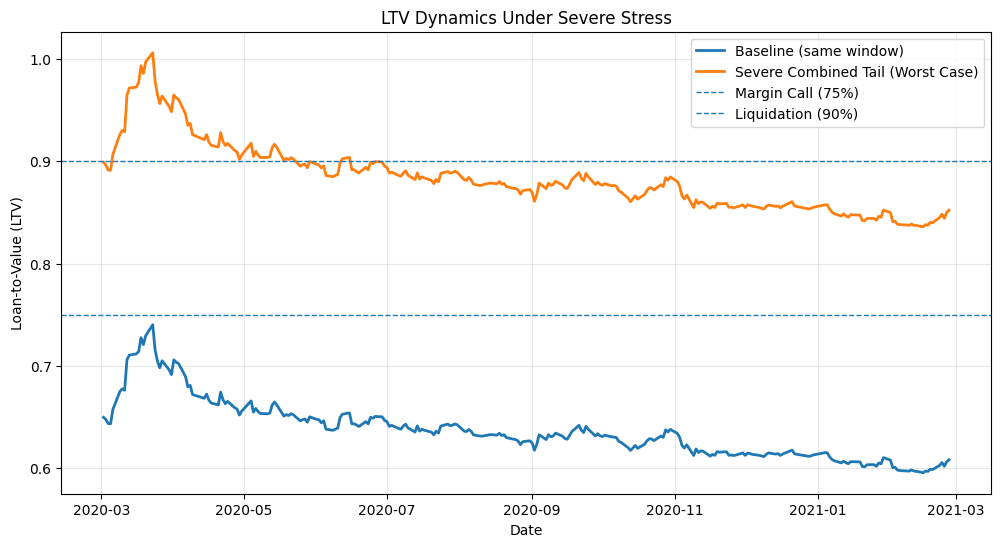

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime index (safety)
LTV_Haircuts_matrix.index = pd.to_datetime(LTV_Haircuts_matrix.index)
worst_case_scenario.index = pd.to_datetime(worst_case_scenario.index)

# Align baseline to the SAME window of the worst case scenario (clean comparison)
start_wc = worst_case_scenario.index.min()
end_wc = worst_case_scenario.index.max()
baseline_wc_window = LTV_Haircuts_matrix.loc[start_wc:end_wc].copy()

plt.figure(figsize=(12, 6))

plt.plot(
    baseline_wc_window.index,
    baseline_wc_window["LTV_daily"],
    label="Baseline (same window)",
    linewidth=2
)

plt.plot(
    worst_case_scenario.index,
    worst_case_scenario["LTV_daily"],
    label="Severe Combined Tail (Worst Case)",
    linewidth=2
)

plt.axhline(margin_call, linestyle="--", linewidth=1, label="Margin Call (75%)")
plt.axhline(liquidation_call, linestyle="--", linewidth=1, label="Liquidation (90%)")

plt.title("LTV Dynamics Under Severe Stress")
plt.ylabel("Loan-to-Value (LTV)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Scenario Summary

The table below summarises the impact of each stress scenario on the Lombard loan, providing a cross-scenario view of maximum LTV levels and risk escalation.

Risk escalation appears gradual and controlled, with liquidation only emerging under extreme combined tail scenarios rather than historical stress alone.


In [14]:
import pandas as pd

def scenario_summary(df, scenario_name, window_label):
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    max_ltv = df["LTV_daily"].max()
    mc_days = int((df["LTV_daily"] >= margin_call).sum())
    liq_days = int((df["LTV_daily"] >= liquidation_call).sum())

    return {
        "Scenario": scenario_name,
        "Stress window": window_label,
        "Max LTV": f"{max_ltv:.2%}",
        "Margin Call breached": "Yes" if mc_days > 0 else "No",
        "Liquidation breached": "Yes" if liq_days > 0 else "No",
        "# MC days": mc_days,
        "# Liq days": liq_days
    }

scenario_summary_df = pd.DataFrame([
    scenario_summary(Equity_crash_scenario, "Equity Crash", "2020-03-01 to 2020-04-30"),
    scenario_summary(Credit_stress_scenario, "Credit Stress", "2022-01-01 to 2022-12-31"),
    scenario_summary(worst_case_scenario, "Severe Combined Tail", "2020-03-01 to 2021-02-28")
])

scenario_summary_df
scenario_summary_df["Key interpretation"] = [
    "Equity-driven stress dominates",
    "Bond stress reduces diversification",
    "Tail overlay can trigger liquidation"
]
scenario_summary_df


,Scenario,Stress window,Max LTV,Margin Call breached,Liquidation breached,# MC days,# Liq days,Key interpretation
0,Equity Crash,2020-03-01 to 2020-04-30,78.71%,Yes,No,13,0,Equity-driven stress dominates
1,Credit Stress,2022-01-01 to 2022-12-31,68.43%,No,No,0,0,Bond stress reduces diversification
2,Severe Combined Tail,2020-03-01 to 2021-02-28,100.63%,Yes,Yes,253,55,Tail overlay can trigger liquidation


## Key Risk Insights

The stress testing results highlight the importance of conservative initial structuring in Lombard lending.  
Under baseline conditions, the loan remains comfortably below margin call thresholds, even during historically severe market episodes.

Stress scenarios show that risk escalation is primarily driven by equity drawdowns, while bond stress becomes more relevant in prolonged tightening environments where diversification benefits weaken.

Only under severe combined tail scenarios do liquidation thresholds become at risk, confirming that margin call buffers provide meaningful protection against short-term market volatility.

Overall, the analysis demonstrates how a diversified collateral pool, combined with conservative haircuts, can materially reduce the likelihood of forced liquidation while still allowing for effective early-warning signals under extreme market conditions.
